# 문서 유사도

    각 문서를 문서 벡터로 변환하는 방법은 패키지인 Doc2Vec, Sent2Vec 등 있지만,
    가장 간단한 방법은 문서의 존재하는 단어 벡터들의 평균을 구하는 것.

    문서 벡터를 활용해 도서 추천 시스템 만들기.
    데이터는 책 참고
   
    데이터 다운로드 링크 : https://drive.google.com/file/d/15Q7DZ7xrJsI2Hji-WbkU9j1mwnODBd5A/view?usp=sharing
    

## 1. 데이터 처리

In [1]:
import pandas as pd

df = pd.read_csv("data.csv")
print("total documents : ",len(df))

total documents :  2382


In [2]:
df.head(5)

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [5]:
# 줄거리에 해당하는 열인 'Desc'에 대해 전처리와 토큰화 진행.
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

def removeNonAscii(s) :
    return "".join(i for i in s if ord(i) < 128)

def makeLowercase(text):
    return text.lower()

def removeStopwords(text):
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [word for word in text if word not in stops]
    text = " ".join(text)
    return text

def removeHTML(text):
    html_pat = re.compile('<.*?>')
    return html_pat.sub(r"",text)

def removePunctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(removeNonAscii)
df['cleaned'] = df.cleaned.apply(makeLowercase)
df['cleaned'] = df.cleaned.apply(removeStopwords)
df['cleaned'] = df.cleaned.apply(removeHTML)
df['cleaned'] = df.cleaned.apply(removePunctuation)

df['cleaned'].replace("",np.nan,inplace=True)
df.dropna(inplace=True)

print("total documents :",len(df))

corpus = []
for words in df['cleaned'] :
    corpus.append(words.split())

total documents : 2381


## 2. 사전 훈련된 워드 임베딩 사용
    
    Word2Vec 를 다운받아 초기 단어 벡터값으로 사용.

In [11]:
import urllib.request
from gensim.models import Word2Vec

urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

word2vec = Word2Vec(size=300, window=5, min_count=2, workers= -1)
word2vec.build_vocab(corpus)
word2vec.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz',lockf=1.0,binary=True)
word2vec.train(corpus,total_examples=word2vec.corpus_count,epochs=15)

(0, 0)

## 3. 단어 벡터의 평균 구하기

In [12]:
def vectors(doc_list) :
    doc_embedding_list = []
    
    for line in doc_list :
        doc2vec = None
        count = 0
        
        for word in line.split():
            if word in word2vec.wv.vocab:
                count += 1
                if doc2vec is None:
                    doc2vec = word2vec[word]
                else :
                    doc2vec = doc2vec + word2vec[word]
        if doc2vec is not None:
            doc2vec = doc2vec / count
            doc_embedding_list.append(doc2vec)
    
    return doc_embedding_list

doc_embedding_list = vectors(df['cleaned'])
print('count of document vectors : ',len(doc_embedding_list))

<ipython-input-12-4f94e9ef7c3c>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec[word]
<ipython-input-12-4f94e9ef7c3c>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec[word]


count of document vectors :  2381


## 4. 추천 시스템 구현하기
    문서 벡타 간의 코사인 유사도 구하기

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(doc_embedding_list, doc_embedding_list)

In [17]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

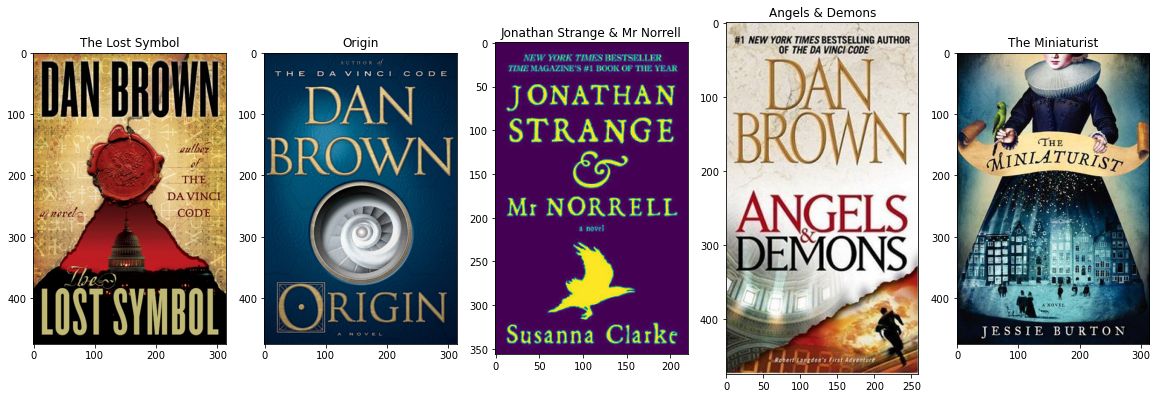

In [18]:
recommendations("The Da Vinci Code")